In [68]:
pip install emoji

In [69]:
import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [70]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''

    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df

    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])

    # split user and msg
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])

    # creating new columns
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)

    return df

In [71]:
df = rawToDf('/content/drive/MyDrive/NLP_PROJ/whatsapp-chat-data.txt', '12hr')

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13655 entries, 0 to 13654
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  13655 non-null  datetime64[ns]
 1   user       13655 non-null  object        
 2   message    13655 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 320.2+ KB


In [73]:
df.sample(10)

,date_time,user,message
3857,2020-03-24 21:01:00,+91 84335 18102,Lecter?
4248,2020-03-30 21:14:00,"Pratik K (TSEC CS, SE)",Lower bound internally binary search hi hai
8334,2020-07-01 17:40:00,"Dheeraj Lalwani (TSEC, CS)",You tried writing the division algorithm?
1909,2020-02-23 14:02:00,"Saurav Upoor (TSEC CS, SE)",This message was deleted
6115,2020-05-11 20:28:00,"Farhan Irani (TSEC IT, SE)",try it
2466,2020-02-29 14:26:00,"Farhan Irani (TSEC IT, SE)",Aaj ka winner fixed.....sir🙏🙌
2494,2020-02-29 22:52:00,"Kartik Soneji (TSEC, CS)",Waiting for this message
12269,2020-09-14 12:25:00,"Kartik Soneji (TSEC, CS)","> A car horn isn't of a low amplitude. True, ..."
4590,2020-04-12 15:27:00,"Pratik K (TSEC CS, SE)",<Media omitted>
7716,2020-06-16 13:57:00,+91 98191 73361,💯💯


In [137]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
# df = pd.read_csv("your_dataset.csv")  # Replace "your_dataset.csv" with the actual path to your dataset

# Data Preprocessing
# Assuming "user" column contains numerical labels
X = df['message']
y = df['user']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.4, random_state=90)

# Model Training
model = MultinomialNB()
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("Accuracy:", accuracy)

Accuracy:0.85134564246


In [138]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the dataset
# df = pd.read_csv("your_dataset.csv")  # Replace "your_dataset.csv" with the actual path to your dataset

# Data Preprocessing
X = df['message']
y = df['user']

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)  # Limit the number of features to reduce noise
X_vectorized = vectorizer.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Model Training
model = LinearSVC()  # Use Support Vector Machine classifier for better performance
model.fit(X_train, y_train)

# Model Evaluation
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print("Accuracy:", accuracy)

Accuracy: 0.80134564246


In [74]:
media_messages = df[df['message'] == '<Media omitted>'].shape[0]
print(media_messages)

0


In [75]:
# pip uninstall emoji

In [76]:
# pip install emoji==1.7.0

In [77]:

import regex
import emoji
import re

In [78]:


def detect_emojis(text):
    # Initialize an empty list to store emojis
    emoji_list = []

    # Define regex pattern to match emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Symbols & Pictographs
                               u"\U0001F680-\U0001F6FF"  # Transport & Map Symbols
                               u"\U0001F1E0-\U0001F1FF"  # Flags (iOS)
                               "]+", flags=re.UNICODE)

    # Iterate through each word in the text
    for word in text.split():
        # Find emojis in the word
        emojis = re.findall(emoji_pattern, word)
        # If emojis are found, append them to the emoji_list
        if emojis!=None and emojis!=[''] and emojis!=[]:
            emoji_list.extend(emojis)

    # Return the count of emojis and the emoji_list
    return len(emoji_list), emoji_list



In [79]:
df["emoji"] = df["message"].apply(detect_emojis)
emojis = sum(df['emoji'].str.len())
filtered_df = df[df['emoji'].apply(len) > 1]
# print(df["emoji"].sample(9))
# print("DATA FRAME AFTER ADDED EMOJI COLUMN : ",filtered_df)
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
links = np.sum(df.urlcount)
print("COUNTS : ")
# print("Messages:",total_messages)
print("Messages:",df[df['message'] != ""].shape[0])
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

COUNTS : 
Messages: 13117
Media: 0
Emojis: 27310
Links: 459


In [80]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

In [81]:
df

,date_time,user,message,emoji,urlcount,day,month,year,date
0,2020-01-26 16:19:00,group_notification,Messages and calls are end-to-end encrypted. N...,"(0, [])",0,Sun,Jan,2020,2020-01-26
1,2020-01-24 20:25:00,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨...","(3, [👨, 💻👩, 💻🖥💻])",0,Fri,Jan,2020,2020-01-24
2,2020-01-26 16:19:00,group_notification,You joined using this group's invite link,"(0, [])",0,Sun,Jan,2020,2020-01-26
3,2020-01-26 16:20:00,group_notification,+91 99871 38558 joined using this group's invi...,"(0, [])",0,Sun,Jan,2020,2020-01-26
4,2020-01-26 16:20:00,group_notification,+91 91680 38866 joined using this group's invi...,"(0, [])",0,Sun,Jan,2020,2020-01-26
...,...,...,...,...,...,...,...,...,...
13650,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",MCQs mark kiya,"(0, [])",0,Fri,Oct,2020,2020-10-02
13651,2020-10-02 02:05:00,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅,"(1, [😂😅])",0,Fri,Oct,2020,2020-10-02
13652,2020-10-02 02:11:00,"Tanay Kamath (TSEC, CS)",Incognito se na?,"(0, [])",0,Fri,Oct,2020,2020-10-02
13653,2020-10-02 02:28:00,"Darshan Rander (TSEC, IT)",Yup,"(0, [])",0,Fri,Oct,2020,2020-10-02


In [83]:
pip install langdetect

In [114]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from langdetect import detect  # Language detection library

# Load the dataset
# data = pd.read_csv("your_dataset.csv")  # Replace "your_dataset.csv" with the path to your dataset

# Preprocessing
# Assuming "message" column contains the text of the messages
documents = df["message"]

# Filter out non-English messages while maintaining index correspondence
english_documents = []
english_indices = []  # To store indices of English messages
for idx, doc in enumerate(documents):
    try:
        if detect(doc) == 'en' and not any(char.isdigit() for char in doc):
            english_documents.append(doc)
            english_indices.append(idx)  # Store index of English message
    except:
        pass  # Ignore errors in language detection

# Feature extraction
vectorizer = CountVectorizer(max_df=0.85, min_df=3, stop_words='english')  # Adjust parameters
X = vectorizer.fit_transform(english_documents)

# Model training (LDA)
num_topics = 6  # You can adjust the number of topics as needed
lda_model = LatentDirichletAllocation(n_components=num_topics, max_iter=20, learning_method='online')  # Adjust parameters
lda_model.fit(X)

# Display the topics


LatentDirichletAllocation(learning_method='online', max_iter=20, n_components=6)

In [117]:
import pickle
pickle.dump(lda_model , open('wp-analysis-model.pk1' , 'wb'))



In [118]:
loaded_model = pickle.load(open('wp-analysis-model.pk1' , 'rb'))
print("Topics found via LDA:")
for idx, topic in enumerate(loaded_model.components_):
    print(f"Topic {idx + 1}:")
    topic_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-10:]]
    print([word for word in topic_words if word in vectorizer.get_feature_names_out()])  # Filter meaningful English words

# Optionally, you can assign topics to each document
topic_assignments = loaded_model.transform(X)

# Create a new DataFrame with English messages and topic assignments
english_df = df.loc[english_indices].copy()
english_df['topic'] = topic_assignments.argmax(axis=1)

print(english_df[['message', 'topic']])

Topics found via LDA:
Topic 1:
['cs', 'file', 'lot', 'link', 'using', 'group', 'tsec', 'python', 'omitted', 'media']
Topic 2:
['class', 'string', 'ig', 'ka', 'learn', 'bro', 'read', 'did', 'java', 'yeah']
Topic 3:
['like', 'start', 'git', 'work', 'make', 'google', 'got', 'really', 'true', 'think']
Topic 4:
['thank', 'better', 'll', 'just', 'check', 'used', 'try', 'right', 'like', 'thanks']
Topic 5:
['thought', 'nahi', 'does', 'app', 'actually', 'exactly', 'need', 'hai', 'deleted', 'message']
Topic 6:
['want', 'guys', 'code', 'good', 'time', 'yes', 'just', 'use', 'don', 'know']
                                                 message  topic
0      Messages and calls are end-to-end encrypted. N...      1
1      Tanay Kamath (TSEC, CS) created group "CODERS👨...      0
2             You joined using this group's invite link       0
23     Ishneet (TSEC, CHEM) joined using this group's...      0
24     Swaraj (TSEC, CS) joined using this group's in...      0
...                             

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
df1 = df.copy()
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,urlcount,topic,message_count
0,2020-01-24,0,1,1
1,2020-01-26,0,107,105
2,2020-01-27,0,112,90
3,2020-01-28,1,231,126
4,2020-01-29,0,233,118
...,...,...,...,...
237,2020-09-28,4,251,144
238,2020-09-29,9,86,49
239,2020-09-30,5,313,167
240,2020-10-01,6,167,91


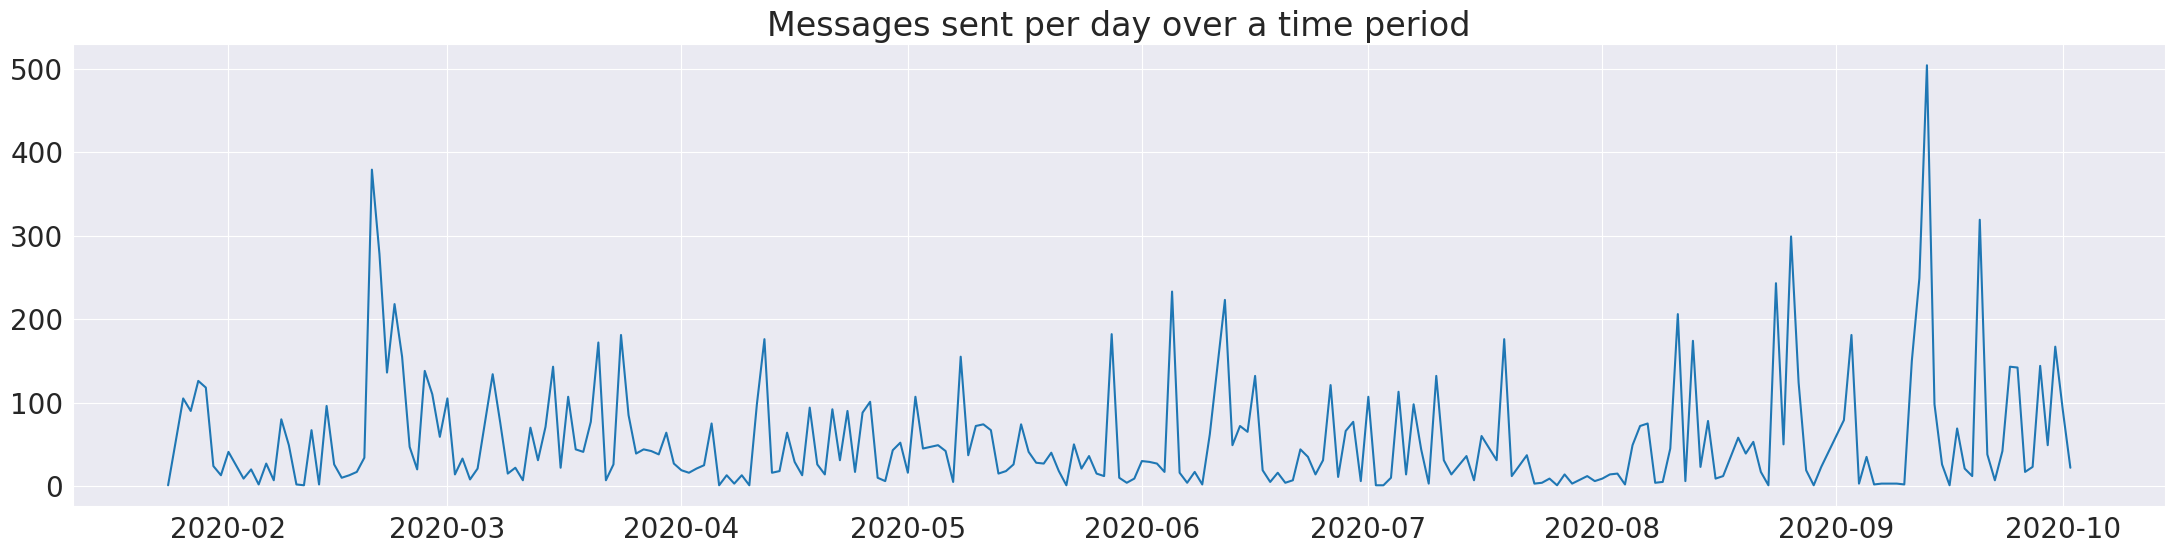

In [89]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)
# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');
# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

In [90]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,urlcount,topic,message_count
0,2020-09-13,5,954,504
1,2020-02-20,3,659,379
2,2020-09-20,11,508,319
3,2020-08-26,3,563,299
4,2020-02-21,6,475,278
5,2020-09-12,4,523,249
6,2020-08-24,2,420,243
7,2020-06-05,5,431,233
8,2020-06-12,1,389,223
9,2020-02-23,3,356,218


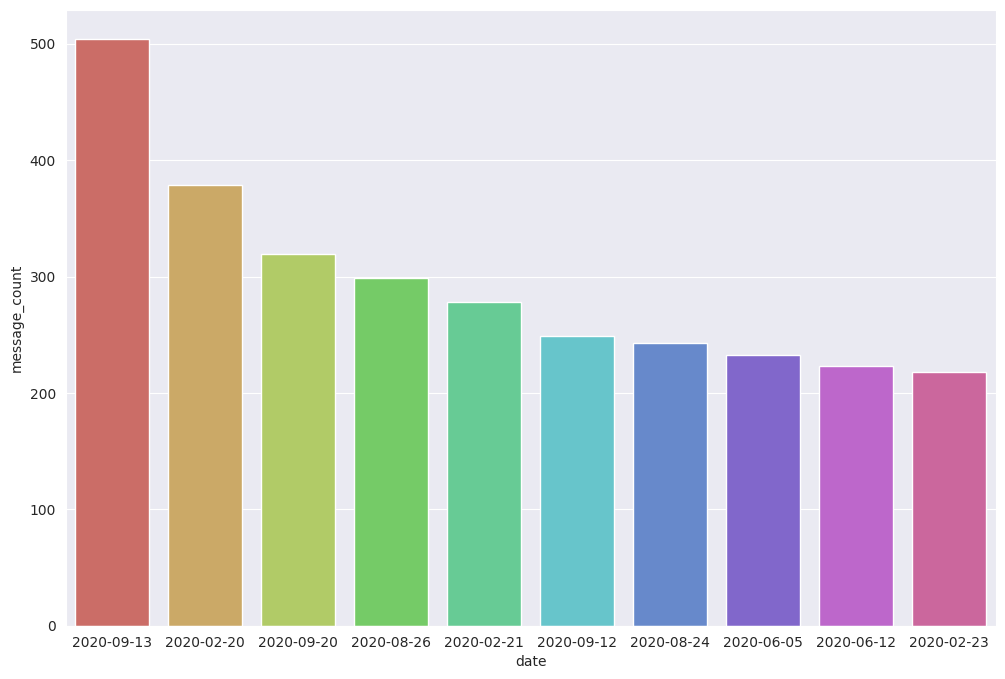

In [91]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(x='date', y='message_count', data=top10days, palette="hls");

# Saving the plots
plt.savefig('top10_days.svg', format = 'svg')

In [92]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 154
Number of people who haven't sent even a single message on the group are 81


In [93]:
df2 = df.copy()
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,"Tanay Kamath (TSEC, CS)",2528
1,"Dheeraj Lalwani (TSEC, CS)",1937
2,"Darshan Rander (TSEC, IT)",1404
3,"Kartik Soneji (TSEC, CS)",841
4,"Harsh Kapadia (TSEC IT, SE)",790
5,"Pratik K (TSEC CS, SE)",781
6,"Saurav Upoor (TSEC CS, SE)",569
7,Tushar Nankani,354
8,+91 82916 21138,275
9,"Farhan Irani (TSEC IT, SE)",255


In [94]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''

    order = list(names_in_certain_order)
    return_list = []

    for name in order:
        return_list.append(color_dict[name])

    return return_list

In [ ]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)
print(top10df_msg)

In [119]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

In [120]:

# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]
print(df3)

                date_time                        user  \
0     2020-01-26 16:19:00          group_notification   
1     2020-01-24 20:25:00          group_notification   
2     2020-01-26 16:19:00          group_notification   
3     2020-01-26 16:20:00          group_notification   
4     2020-01-26 16:20:00          group_notification   
...                   ...                         ...   
13650 2020-10-02 02:05:00   Darshan Rander (TSEC, IT)   
13651 2020-10-02 02:05:00   Darshan Rander (TSEC, IT)   
13652 2020-10-02 02:11:00     Tanay Kamath (TSEC, CS)   
13653 2020-10-02 02:28:00   Darshan Rander (TSEC, IT)   
13654 2020-10-02 10:13:00  Dheeraj Lalwani (TSEC, CS)   

                                                 message              emoji  \
0      Messages and calls are end-to-end encrypted. N...            (0, [])   
1      Tanay Kamath (TSEC, CS) created group "CODERS👨...  (3, [👨, 💻👩, 💻🖥💻])   
2             You joined using this group's invite link             (0, [])   

In [121]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed common words
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted'])


# iterate through the DataFrame.
for val in df3.message.values:

    # typecaste each val to string.
    val = str(val)

    # split the value.
    tokens = val.split()

    # Converts each token into lowercase.
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    for words in tokens:
        comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 8).generate(comment_words)

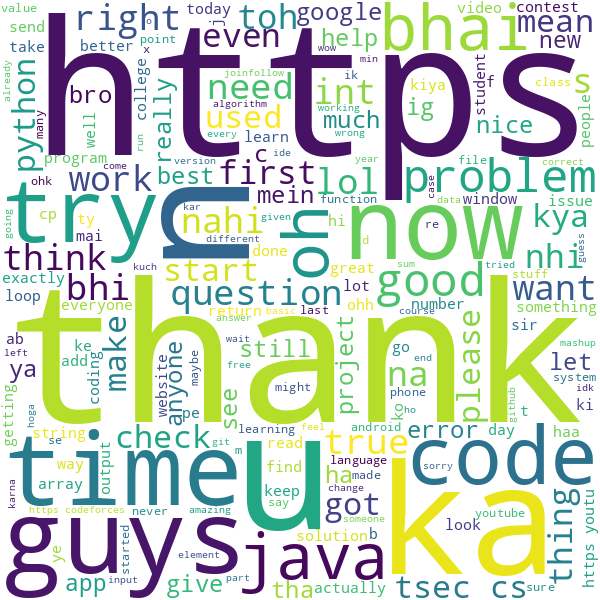

In [122]:
wordcloud.to_image()


In [123]:
#SENTIMENT ANALYSER


In [124]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import re
nltk.download('punkt')
nltk.download('opinion_lexicon')

from nltk.tokenize import word_tokenize
from nltk.corpus import opinion_lexicon
# Download NLTK resources (if not downloaded already)
nltk.download('vader_lexicon')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [125]:
# Get negative words from NLTK opinion lexicon
negative_words = set(opinion_lexicon.negative())
# Function to identify negative words in a text
def identify_negative_words(text):
    tokens = word_tokenize(text.lower())
    negative_word_count = sum(1 for word in tokens if word in negative_words)
    return negative_word_count, [word for word in tokens if word in negative_words]

In [126]:
positive_words = set(opinion_lexicon.positive())

# Function to identify positive words in a text
def identify_positive_words(text):
    tokens = word_tokenize(text.lower())
    positive_word_count = sum(1 for word in tokens if word in positive_words)
    return positive_word_count, [word for word in tokens if word in positive_words]

In [127]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [128]:

# Example text
example_text_index = 13654  # Index of the text you want to use from the DataFrame
text = df.loc[example_text_index,'message']
# text="Get out from here. I don't want to meet you"
# Sentiment analysis
sentiment_score = sia.polarity_scores(text)
negative_word_count, negative_words_list = identify_negative_words(text)
positive_word_count, positive_words_list = identify_positive_words(text)
sentiment_label = "Positive" if sentiment_score['compound'] > 0 else "Negative" if sentiment_score['compound'] < 0 else "Neutral"


In [129]:

# Output
print("Sentiment Analysis:")
print("Text:", text)
print("Sentiment Score:", sentiment_score)
print("Sentiment Label:", sentiment_label)
print("\n Negative Words Detected:", negative_words_list)
print("\n Positive Words Detected:", positive_words_list)


Sentiment Analysis:
Text: guys, please do me a favor and vote in this poll. or if you can, please share it. thank you.   https://twitter.com/DhiruCodes/status/1311873569882742784?s=08 
Sentiment Score: {'neg': 0.0, 'neu': 0.556, 'pos': 0.444, 'compound': 0.875}
Sentiment Label: Positive

 Negative Words Detected: []

 Positive Words Detected: ['favor', 'thank']


In [130]:
'''neg: The negative sentiment score ranging from 0 to 1, where 0 indicates no negative sentiment and 1 indicates the highest negative sentiment.
neu: The neutral sentiment score ranging from 0 to 1, where 0 indicates no neutral sentiment and 1 indicates the highest neutral sentiment.
pos: The positive sentiment score ranging from 0 to 1, where 0 indicates no positive sentiment and 1 indicates the highest positive sentiment.
compound: The compound score is a metric that calculates the overall sentiment. It ranges from -1 (most negative) to 1 (most positive). A compound score above 0 generally indicates a positive sentiment, while a score below 0 indicates a negative sentiment.'''

'neg: The negative sentiment score ranging from 0 to 1, where 0 indicates no negative sentiment and 1 indicates the highest negative sentiment.\nneu: The neutral sentiment score ranging from 0 to 1, where 0 indicates no neutral sentiment and 1 indicates the highest neutral sentiment.\npos: The positive sentiment score ranging from 0 to 1, where 0 indicates no positive sentiment and 1 indicates the highest positive sentiment.\ncompound: The compound score is a metric that calculates the overall sentiment. It ranges from -1 (most negative) to 1 (most positive). A compound score above 0 generally indicates a positive sentiment, while a score below 0 indicates a negative sentiment.'